In [4]:
import sys
from pathlib import Path

PROJECT_ROOT = Path().resolve().parent  # notebooks/ -> project root
sys.path.insert(0, str(PROJECT_ROOT))
print("Project root on path:", PROJECT_ROOT)

Project root on path: /Users/chang/Dropbox/UTAustin/Deep Learning/project


In [ ]:
import torch
import pandas as pd
from pathlib import Path
from PIL import Image
from IPython.display import display
# from data.mvsa_mv import MVSA_MV
from models.text_only import TextClassifier
from models.image_only import ImageClassifier
from models.multimodal import MultimodalClassifier


SPLITS = {
    "train": PROJECT_ROOT / "data/MVSA/splits/train.csv",
    "valid": PROJECT_ROOT / "data/MVSA/splits/valid.csv",
    "test": PROJECT_ROOT / "data/MVSA/splits/test.csv",
}
TARGET_COL = {"text_only": "text_label", "image_only": "image_label", "multimodal": "combined_label"}

device = torch.device("mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu"))

def build_label_maps(target_col):
    df = pd.read_csv(SPLITS["train"])
    labels = sorted(df[target_col].dropna().unique())
    label2id = {l: i for i, l in enumerate(labels)}
    id2label = {i: l for l, i in label2id.items()}
    return label2id, id2label

def load_trained_model(model_key, checkpoint_path):
    label2id, id2label = build_label_maps(TARGET_COL[model_key])
    num_labels = len(label2id)

    if model_key == "text_only":
        model = TextClassifier(num_labels=num_labels)
        tokenizer = model.tokenizer
        image_processor = None
    elif model_key == "image_only":
        model = ImageClassifier(num_labels=num_labels, label2id=label2id, id2label=id2label)
        tokenizer = None
        image_processor = model.processor
    else:  # multimodal
        model = MultimodalClassifier(num_labels=num_labels)
        tokenizer = model.tokenizer
        image_processor = model.image_processor

    state = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(state, strict=False)
    model.to(device).eval()
    return model, tokenizer, image_processor, id2label

def show_sample(idx, split="valid", model_key="text_only"):
    df = pd.read_csv(SPLITS[split])
    row = df.iloc[idx]

    text = Path(row["text_path"]).read_text(encoding="utf-8").strip()
    img = Image.open(row["image_path"]).convert("RGB")
    label = row[TARGET_COL[model_key]]

    print(f"[{split}] idx={idx}")
    print(f"Label: {label}")
    print(f"Text:\n{text}\n")
    display(img)
    return row, text, img, label

@torch.no_grad()
def predict_sample(idx, split="valid", model_key="text_only", checkpoint_path=None):
    assert checkpoint_path is not None, "Provide checkpoint_path"
    model, tokenizer, image_processor, id2label = load_trained_model(model_key, checkpoint_path)
    _, text, img, true_label = show_sample(idx, split=split, model_key=model_key)

    inputs = {}
    if tokenizer is not None:
        enc = tokenizer(text, padding="max_length", truncation=True, max_length=256, return_tensors="pt")
        inputs.update({k: v.to(device) for k, v in enc.items()})
    if image_processor is not None:
        img_enc = image_processor(images=img, return_tensors="pt")
        inputs.update({k: v.to(device) for k, v in img_enc.items()})

    outputs = model(**inputs)
    logits = outputs["logits"] if isinstance(outputs, dict) else outputs.logits
    pred_id = logits.argmax(dim=-1).item()
    pred_label = id2label[pred_id]

    print(f"True label: {true_label}")
    print(f"Predicted: {pred_label}")
    return pred_label

# Example usage:
# predict_sample(idx=0, split="valid", model_key="text_only",
#                checkpoint_path=PROJECT_ROOT / "outputs/checkpoints/text_only_best.pt")


/opt/anaconda3/envs/mvsa/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[valid] idx=11
Label: neutral
Text:
Still got it. Whos tryin to get stomped on?



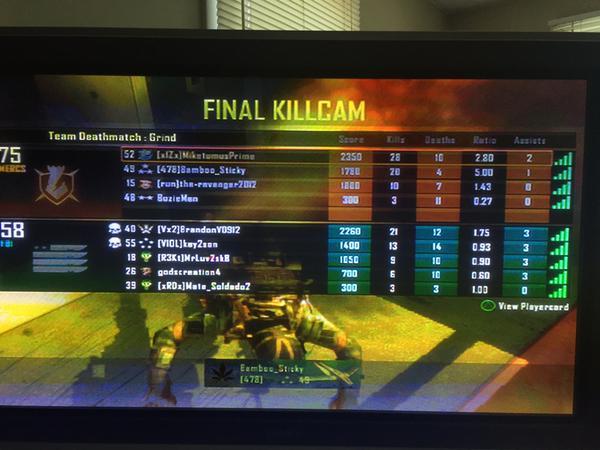

True label: neutral
Predicted: neutral


'neutral'

In [29]:
predict_sample(idx=11, split="valid", model_key="text_only",
                checkpoint_path=PROJECT_ROOT / "outputs/checkpoints/text_only_best.pt")

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[valid] idx=11
Label: neutral
Text:
Still got it. Whos tryin to get stomped on?



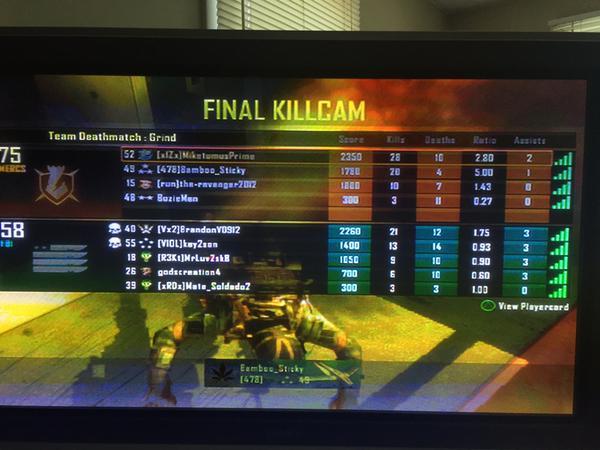

True label: neutral
Predicted: negative


'negative'

In [30]:
predict_sample(idx=11, split="valid", model_key="multimodal",
                checkpoint_path=PROJECT_ROOT / "outputs/checkpoints/text_only_best.pt")